In [1]:
import torch, torchvision
import os

In [5]:
# We need to pre-process the data before we can use it

import cv2 # Module that will help us to work with images
import imghdr # Check file extension
from matplotlib import pyplot as plt # Display images

C:\Users\kevin\AppData\Local\Temp\ipykernel_18564\1475044879.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr # Check file extension


In [6]:
data_dir = "data" # points to the data directory

# Remove all files that are under 9 KB manually first
image_exts = ["jpg", "jpeg", "png", "bmp"]

In [7]:
for image_class in os.listdir(data_dir): # happy or sad
    for image in os.listdir(os.path.join(data_dir, image_class)): # images
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                os.remove(image_path)
                print(f"Removed {image_path}")
        except Exception as e:
            print(f"Error with {image_path}: {e}")

# .join() method is used to join the elements of an iterable to the end of the string


In [8]:
# img = cv2.imread(os.path.join(data_dir, "happy", "1HEoLBLidT2u4mhJ0oiDgig.png"))
# img.shape
# plt.imshow(img) # Notice the colors are off -> OpenCV uses BGR instead of RGB
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Convert BGR to RGB

In [9]:
from torchvision import datasets, transforms 
# datasets: common datasets such as ImageNet, CIFAR10, MNIST, etc.
# transforms: common image transformations such as RandomCrop, Normalize, etc.
from torch.utils.data import DataLoader, random_split
# DataLoader: provides an iterable over the given dataset
# random_split: splits a dataset into random non-overlapping datasets of given lengths

In [10]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [11]:
data_iterator = iter(dataloader)

In [12]:
batch = next(data_iterator) # Batch of data, it has length 2 because we have 2 parts: labels and images

In [13]:
batch[1] # Bunch of 0s and 1s, 0 for happy and 1 for sad

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 1, 0, 1])

In [14]:
# batch = next(data_iterator)
# batch[0].min() # Maximum value in the tensor

In [15]:
len(dataloader) # 7 batches of 32 images

7

In [16]:
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [18]:
# Begin modeling now ! 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # Optimizers such as SGD, Adam, etc.

# MaxPooling2D: reduces the spatial dimensions of the output volume
# Conv2D: applies a 2D convolution over an input signal
# Dense: fully connected layer
# Flatten: flattens the input -> used to convert a 2D matrix into a vector
# Dropout: applies dropout to the input
# ReLU: applies the rectified linear unit activation function (keeps only positive values)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train(epoch):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pred = output.round()
        correct += pred.eq(target.float().view_as(pred)).sum().item()
        total += target.size(0)
        
        if batch_idx % 2 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item()}")
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100. * correct / total
    train_losses.append(avg_loss)
    train_accuracies.append(accuracy)
    print(f"Train set: Average loss: {avg_loss}, Accuracy: {correct}/{total} ({accuracy:.2f}%)")

def test():
    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target.float().view(-1, 1)).item()
            pred = output.round()
            correct += pred.eq(target.float().view_as(pred)).sum().item()
            total += target.size(0)
    
    test_loss /= len(val_loader)
    accuracy = 100. * correct / total
    val_losses.append(test_loss)
    val_accuracies.append(accuracy)
    print(f"\nTest set: Average loss: {test_loss}, Accuracy: {correct}/{total} ({accuracy:.2f}%)\n")


In [20]:
for epoch in range(1, 21):
    train(epoch)
    test()

Train Epoch: 1 [0/135 (0%)]	Loss: 0.6966291069984436
Train Epoch: 1 [64/135 (40%)]	Loss: 0.6494287252426147
Train Epoch: 1 [28/135 (80%)]	Loss: 0.6365594863891602
Train set: Average loss: 0.6756702899932862, Accuracy: 73/135 (54.07%)

Test set: Average loss: 0.7152040004730225, Accuracy: 19/38 (50.00%)

Train Epoch: 2 [0/135 (0%)]	Loss: 0.6411774754524231
Train Epoch: 2 [64/135 (40%)]	Loss: 0.693462610244751
Train Epoch: 2 [28/135 (80%)]	Loss: 0.5677697658538818
Train set: Average loss: 0.626034963130951, Accuracy: 83/135 (61.48%)

Test set: Average loss: 0.6864925026893616, Accuracy: 22/38 (57.89%)

Train Epoch: 3 [0/135 (0%)]	Loss: 0.5727611780166626
Train Epoch: 3 [64/135 (40%)]	Loss: 0.4656728506088257
Train Epoch: 3 [28/135 (80%)]	Loss: 0.6558387279510498
Train set: Average loss: 0.5482497751712799, Accuracy: 103/135 (76.30%)

Test set: Average loss: 0.5092242807149887, Accuracy: 28/38 (73.68%)

Train Epoch: 4 [0/135 (0%)]	Loss: 0.4466719329357147
Train Epoch: 4 [64/135 (40%)]	Los

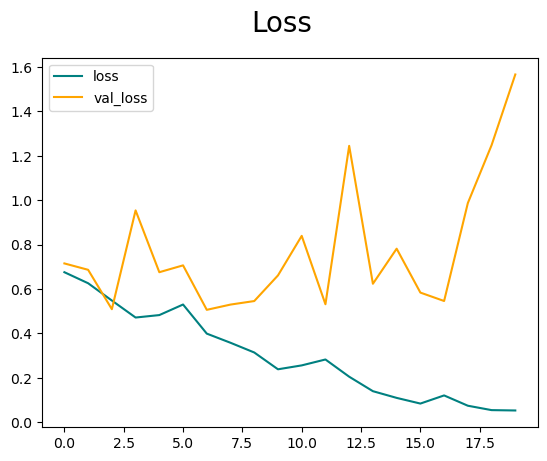

In [21]:
fig = plt.figure()
plt.plot(train_losses, color='teal', label='loss')
plt.plot(val_losses, color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

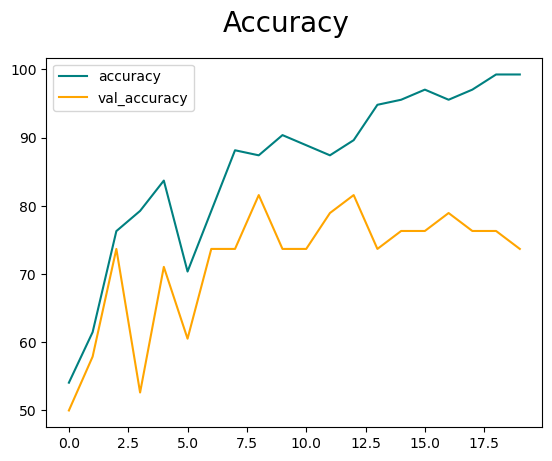

In [22]:
fig = plt.figure()
plt.plot(train_accuracies, color='teal', label='accuracy')
plt.plot(val_accuracies, color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [27]:
import torch
from torchmetrics import Precision, Recall, Accuracy

# Define metrics
pre = Precision(task='binary')
re = Recall(task='binary')
acc = Accuracy(task='binary')

# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model and metrics to the appropriate device
model = model.to(device)
pre = pre.to(device)
re = re.to(device)
acc = acc.to(device)

# Assume 'model' is your PyTorch model and 'test_loader' is your PyTorch DataLoader
model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    for X, y in test_loader:
        # Move input and labels to the same device as the model
        X, y = X.to(device), y.to(device)
        
        yhat = model(X)
        yhat = yhat.squeeze(1)  # Remove the extra dimension to match y
        
        pre(yhat, y)
        re(yhat, y)
        acc(yhat, y)

print(f"Precision: {pre.compute():.4f}, Recall: {re.compute():.4f}, Accuracy: {acc.compute():.4f}")
# Precision: 0.1 Recall: 0.7 Accuracy: 0.85

Precision: 1.0000, Recall: 0.7000, Accuracy: 0.8571


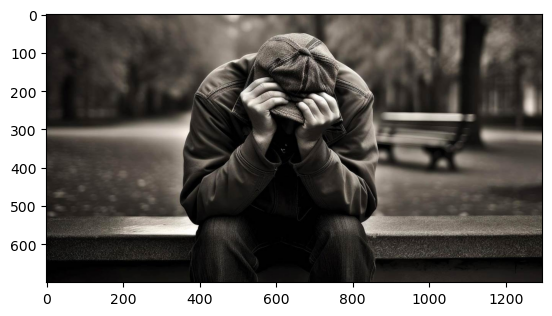

In [58]:
import cv2
img = cv2.imread(r'.\data\sad\How-to-handle-Grief.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [59]:
from PIL import Image
from torchvision import transforms
import numpy as np

img_pil = Image.fromarray(img)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_transformed = transform(img_pil)
img_transformed = img_transformed.unsqueeze(0)
img_transformed = img_transformed.to(device)

In [60]:
model.eval() # Set the model to evaluation mode
with torch.no_grad():
    # torch.no_grad() disables gradient calculation, saving memory
    output = model(img_transformed)
    prediction = torch.sigmoid(output).item()

print(f"Prediction: {prediction}")

Prediction: 0.7310482859611511


In [61]:
# Display the prediction
if prediction > 0.5:
    print("The model predicts: Sad")
else:
    print("The model predicts: Happy")

The model predicts: Sad


In [63]:
model_path = os.path.join("models", "model.pth")
torch.save(model.state_dict(), model_path)
